# **1. GENERAL**

# **2. ENVIRONMENT SETUP**

## **2.1 Extend package**

In [115]:
pip install tensorflow # type: ignore

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [116]:
pip install wandb # type: ignore

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [117]:
pip install scikit-learn # type: ignore

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [118]:
pip install seaborn # type: ignore

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## **2.2 Library**

In [388]:
import wandb # type: ignore
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from wandb.integration.keras import WandbCallback
# from google.colab import drive # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

## **2.3 WanDB**


In [120]:
wandb.login(relogin=True) 

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# **3. DATA LOADING**

## **3.1 Mounting**

In [121]:
"""
Attention:
- This data loading method only available on colab.
- For others platform, please follow their guide.
- For local environment, dont need
"""
# drive.mount('/content/drive')

'\nAttention:\n- This data loading method only available on colab.\n- For others platform, please follow their guide.\n- For local environment, dont need\n'

In [394]:
pd.set_option('display.max_columns', None) # Setup to show full columns in DataFrame

# df = pd.read_csv('/content/drive/MyDrive/data.csv')
df = pd.read_csv('/home/nguyen-quang-huy/GITHUB/My_Repo/AirForce/ai/data/final_dataset.csv') # For local environment

## **3.2 Quick glance**

In [399]:
df.drop(columns=['temp', 'wind_speed', 'humidity', 'pressure', 'tempo_no2', "tempo_hcho", 'wind_dir'], inplace=True)

In [396]:
df.describe()

,lat,lon,pm25,pm10,no2,co,so2,o3,temp,wind_speed,wind_dir,humidity,pressure,tempo_no2,tempo_hcho
count,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000,68141.000000
mean,37.926770,-93.067895,8.756822,19.701639,9.369790,0.244709,0.561693,0.029728,15.059630,2.129934,189.520453,60.473672,1149.539570,0.000299,0.000100
std,5.048448,14.996883,6.598712,13.983629,6.693472,0.149247,1.013562,0.011379,10.340277,1.446804,64.228356,19.366738,1883.506217,0.000115,0.000028
min,27.965650,-147.727413,-4.247917,-1.000000,-4.463636,-0.210417,-1.720807,0.000000,-35.809028,0.000000,0.047619,0.000000,39.016667,0.000100,0.000050
25%,33.999580,-104.778334,4.879167,11.000000,4.625000,0.166396,0.100000,0.021412,8.002315,1.166073,147.750000,47.958333,981.475000,0.000202,0.000076
50%,38.656429,-90.198348,7.350000,17.000000,7.650000,0.209066,0.308421,0.029588,16.365741,1.783406,191.216667,63.041667,994.900000,0.000300,0.000100
75%,41.182227,-80.785683,10.850000,24.000000,12.258333,0.282938,0.693750,0.037824,23.194444,2.713692,235.416667,74.541667,1008.250000,0.000398,0.000124
max,64.845690,-71.082600,190.704688,445.000000,140.650000,2.297619,33.457143,0.082529,41.597222,14.899584,354.625000,100.000000,22388.750000,0.000500,0.000150


In [400]:
df.columns

Index(['date', 'lat', 'lon', 'pm25', 'pm10', 'no2', 'co', 'so2', 'o3'], dtype='object')

In [397]:
def _plot_dis(df):
    for col in df.columns:
        if col != 'date':
            plt.figure(figsize=(20,6))
            sns.histplot(df[col], kde=True, bins=30)
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Volume')
            plt.show()

def _box_plot(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            plt.figure(figsize=(20,6))
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col}')
            plt.show()

## **3.3 Cleaning**

In [401]:
import pandas as pd

def filter_outliers_iqr(df, cols_to_filter, iqr_multiplier=1.5):
    for col in cols_to_filter:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

cols_to_filter = ['pm25', 'pm10', 'no2', 'co', 'so2', 'o3']
df = filter_outliers_iqr(df, cols_to_filter)

print(df.shape)


(53000, 9)


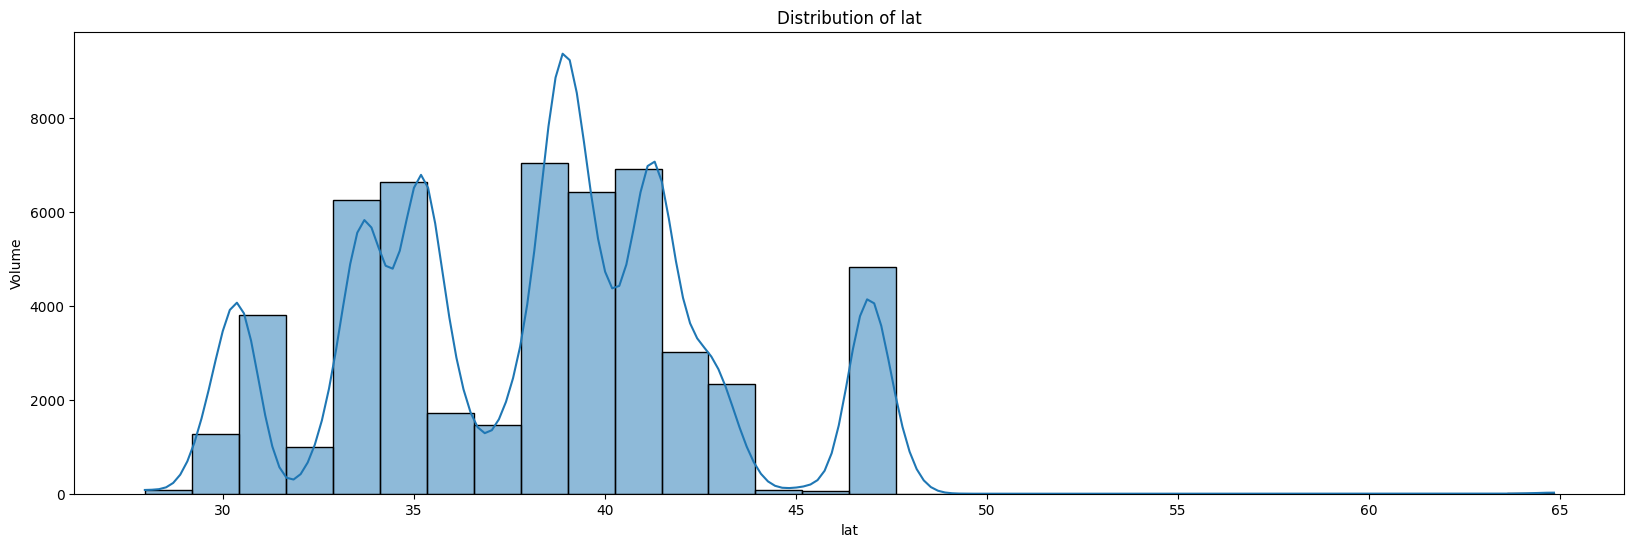

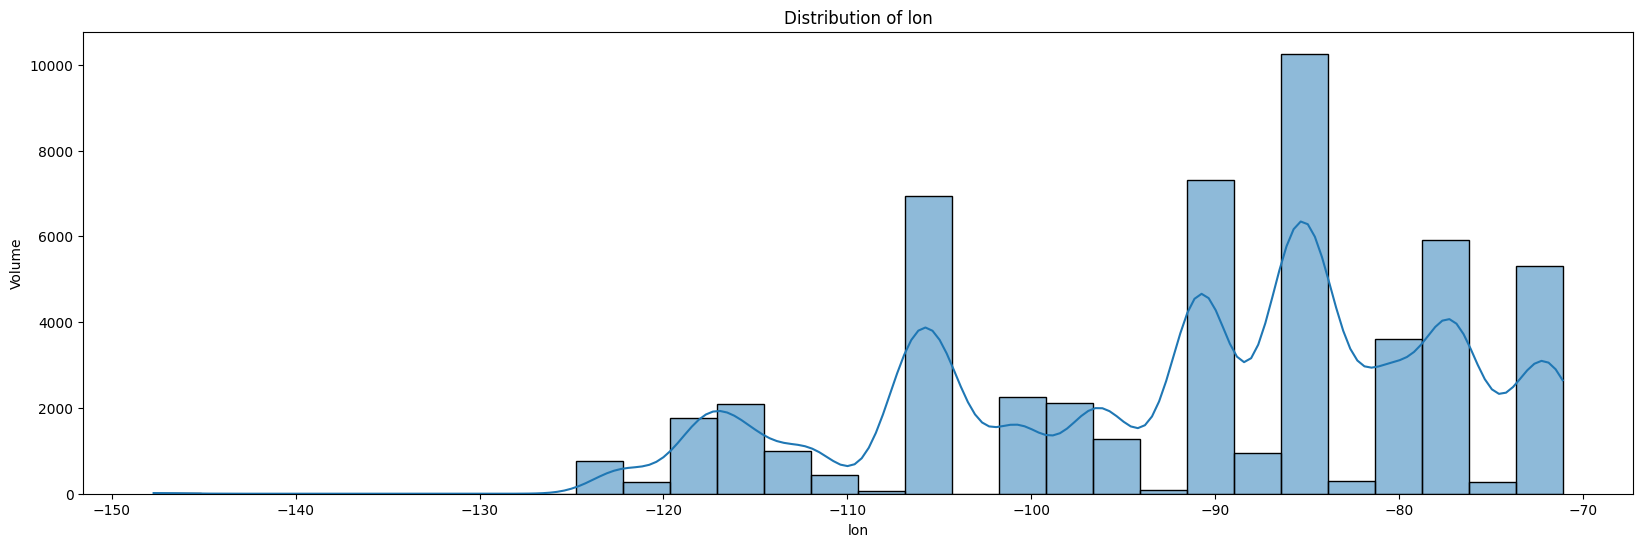

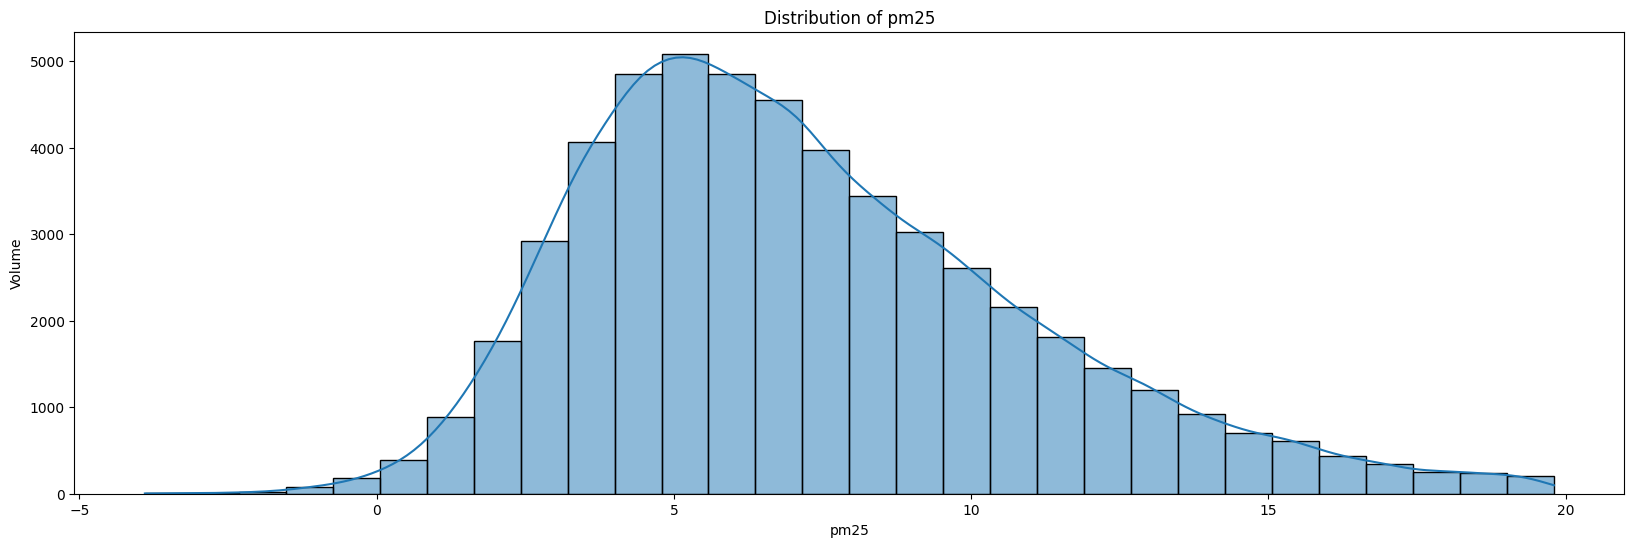

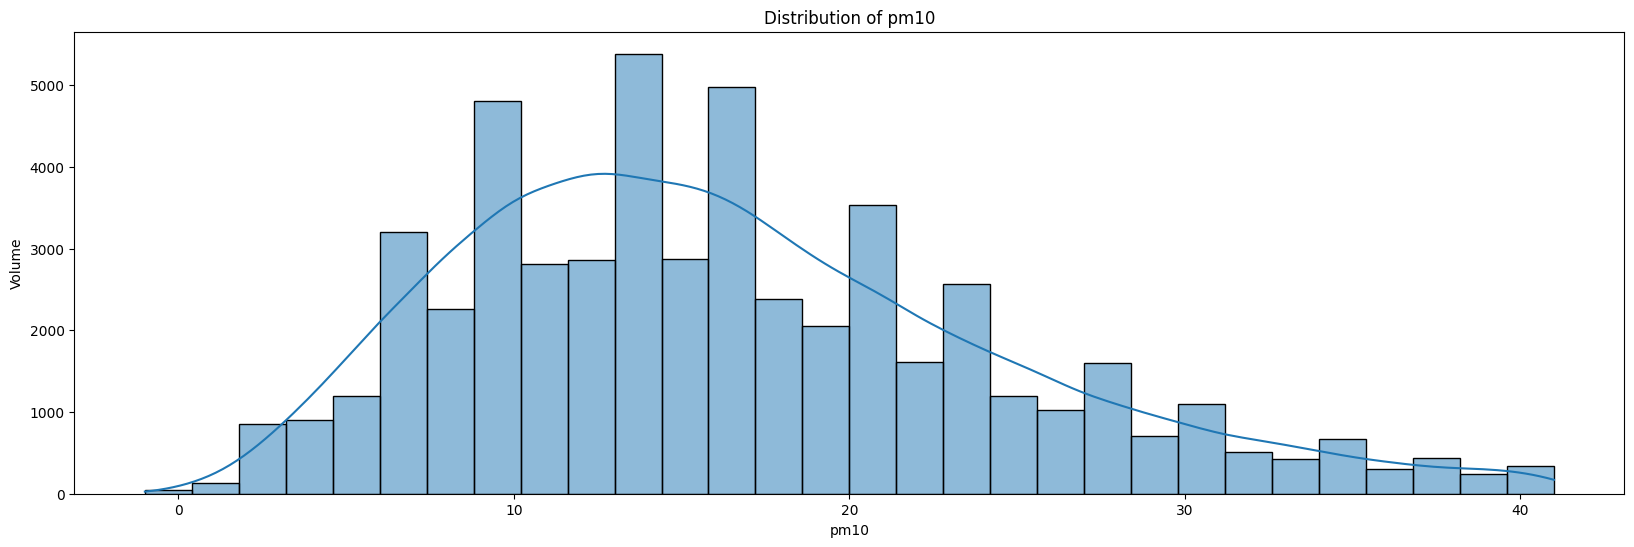

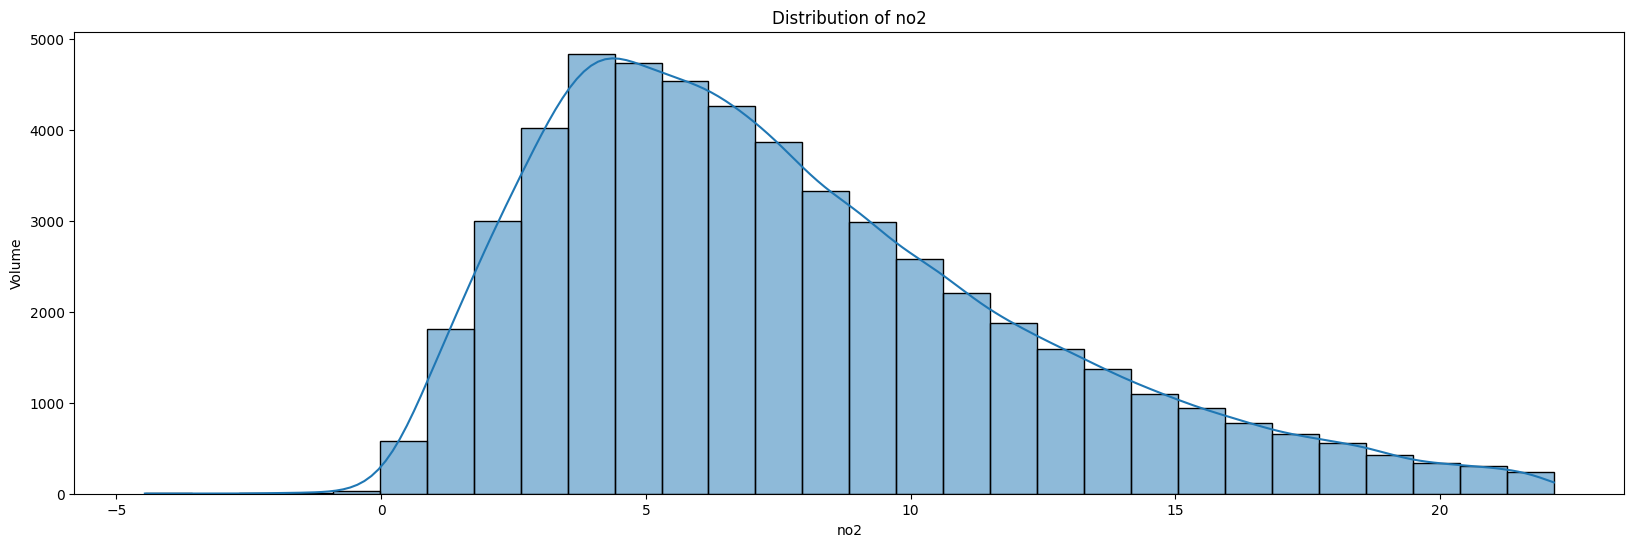

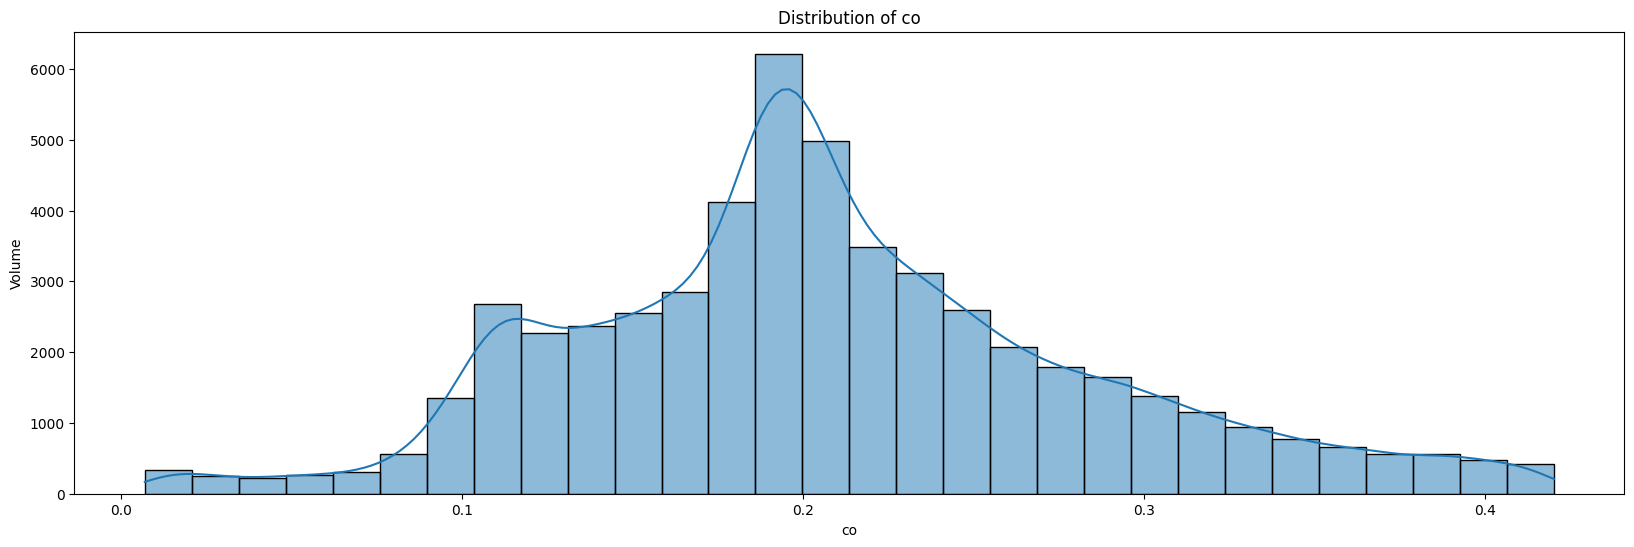

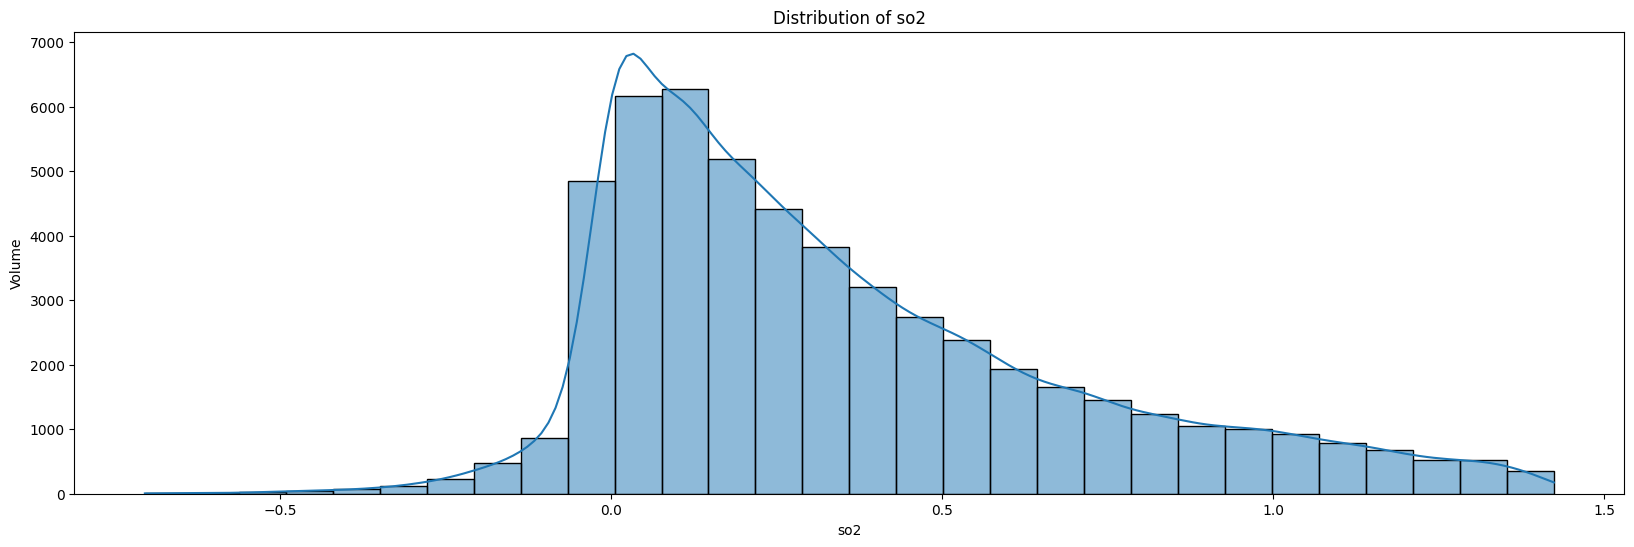

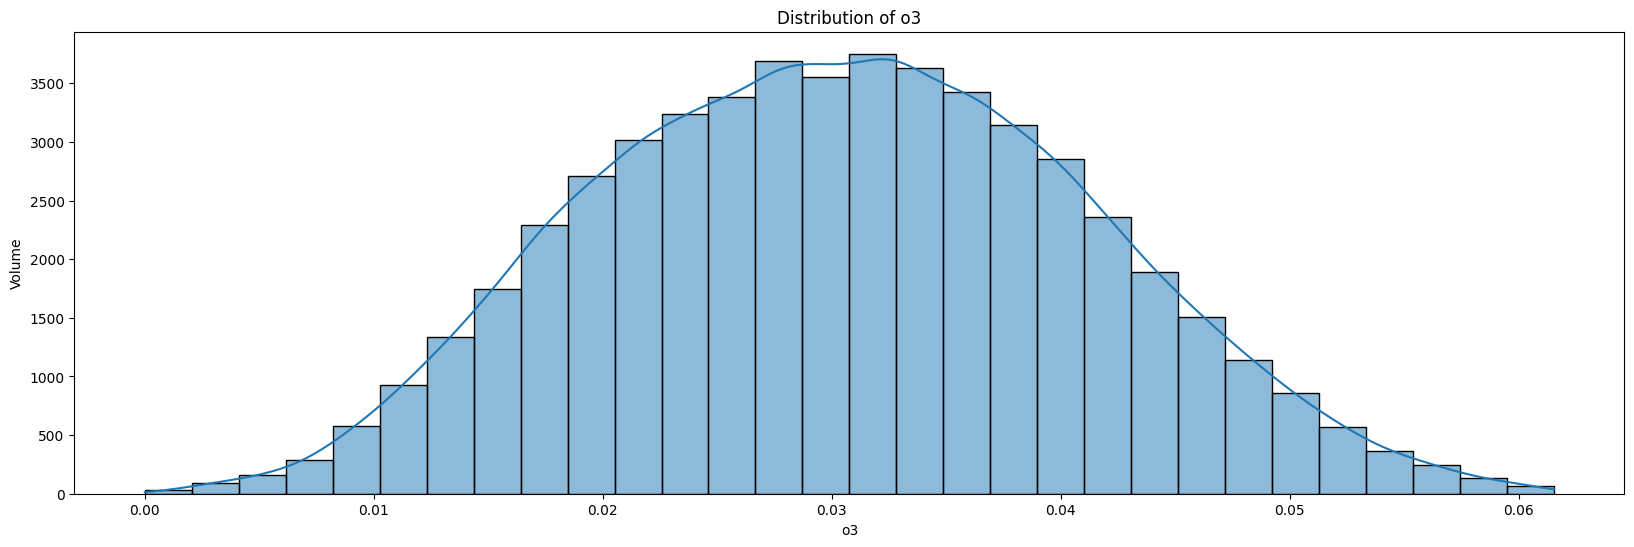

In [402]:
_plot_dis(df)

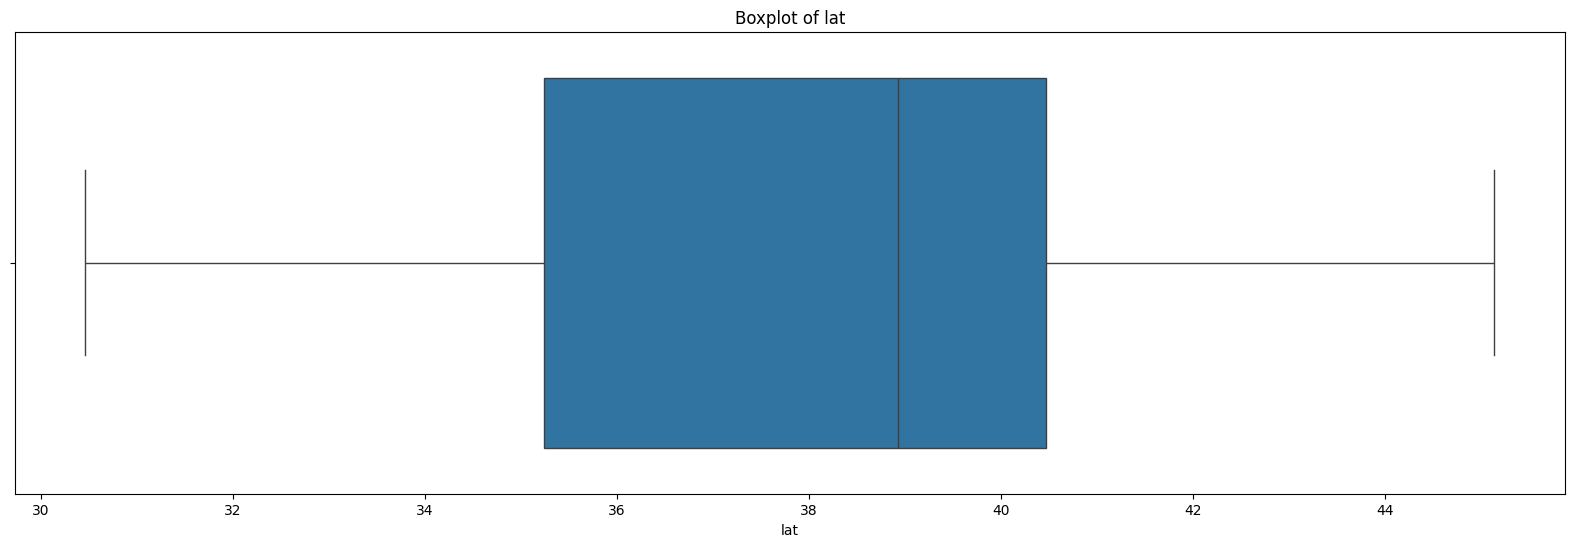

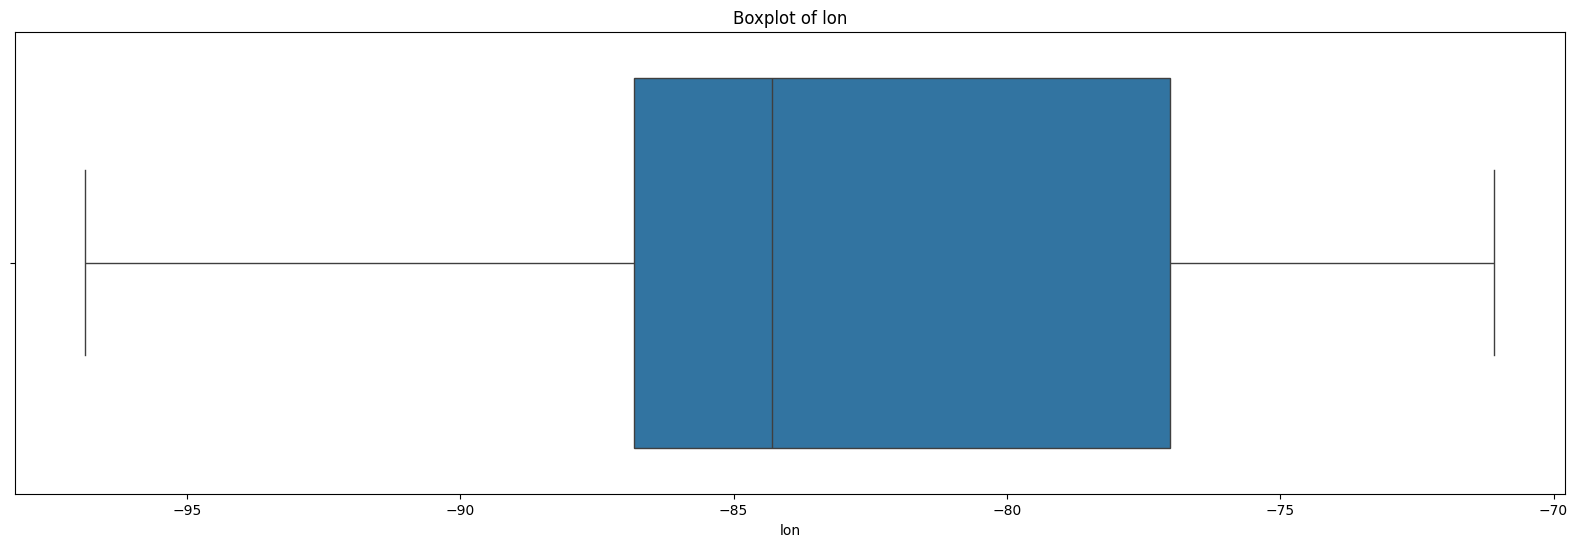

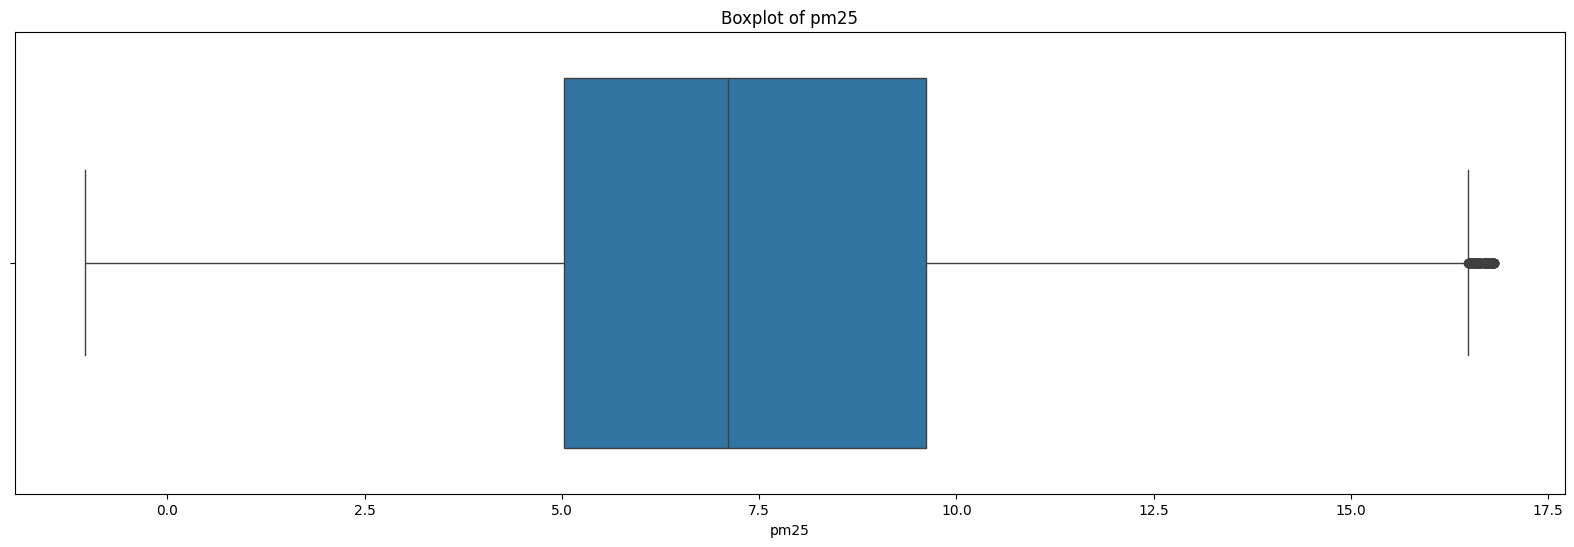

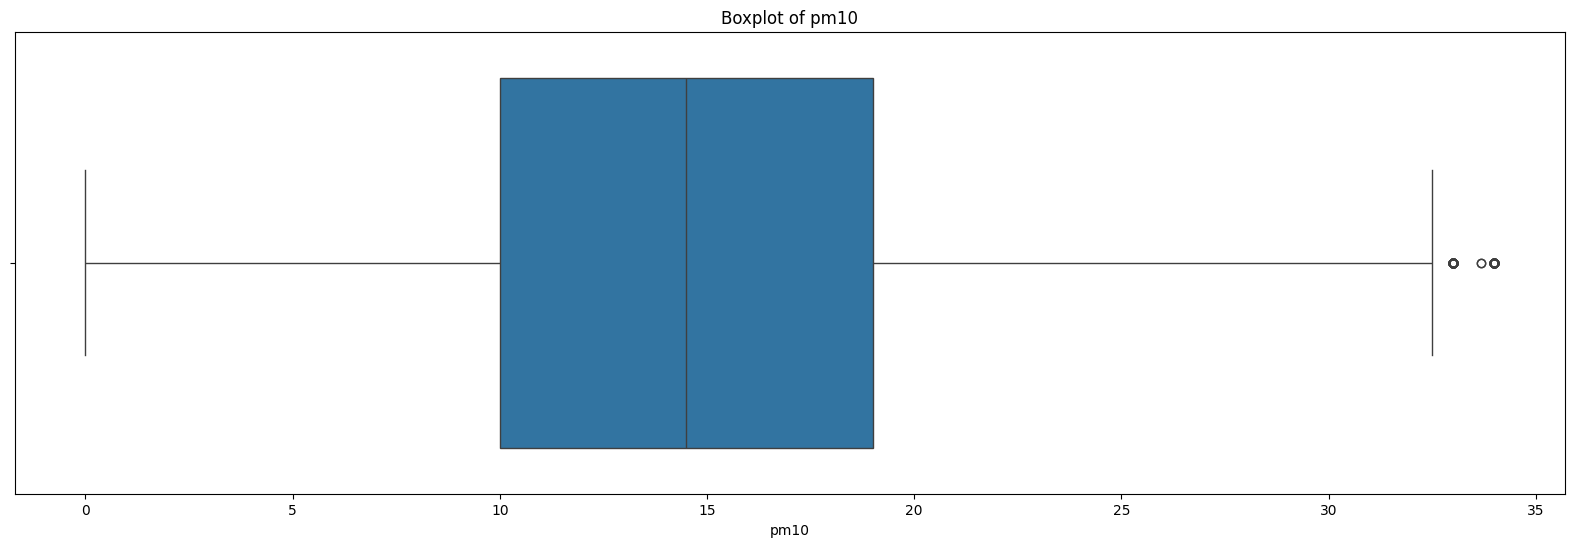

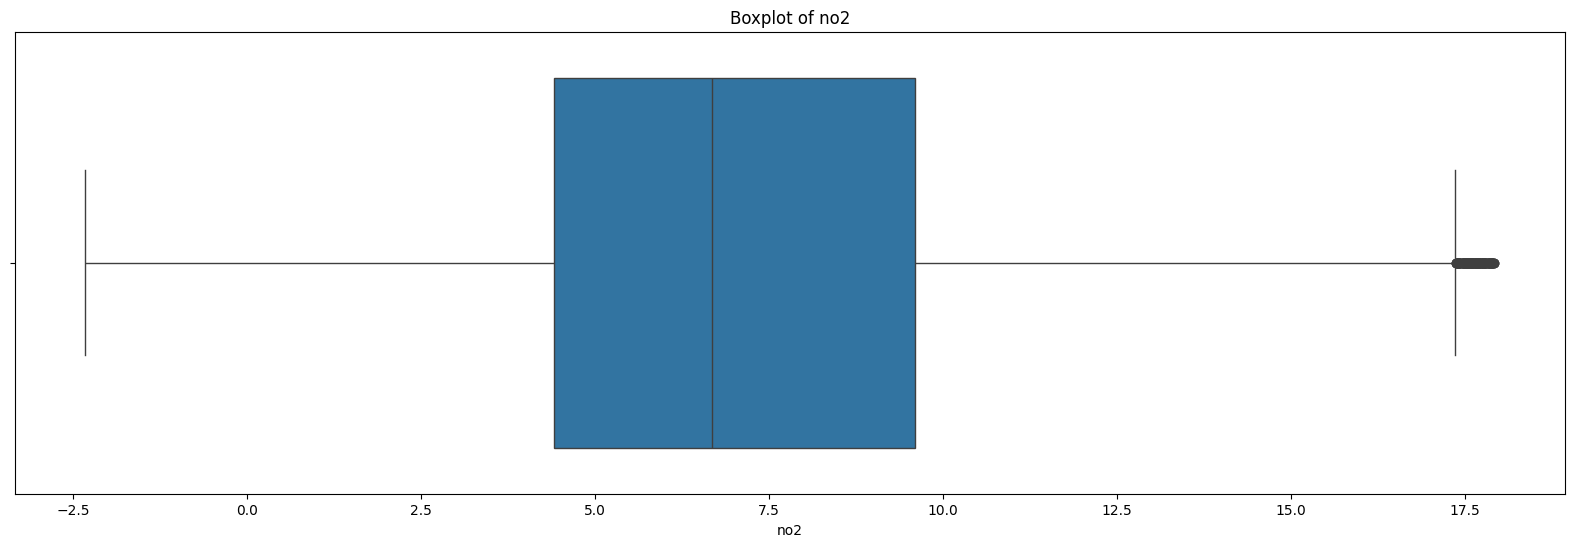

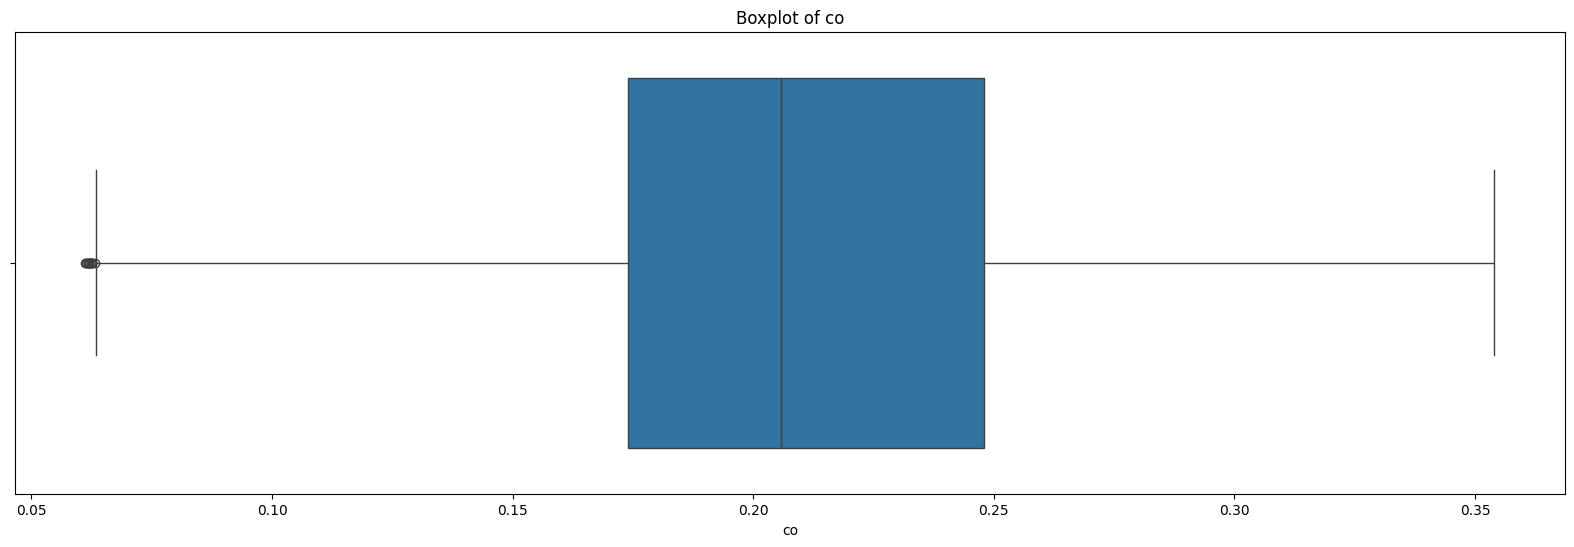

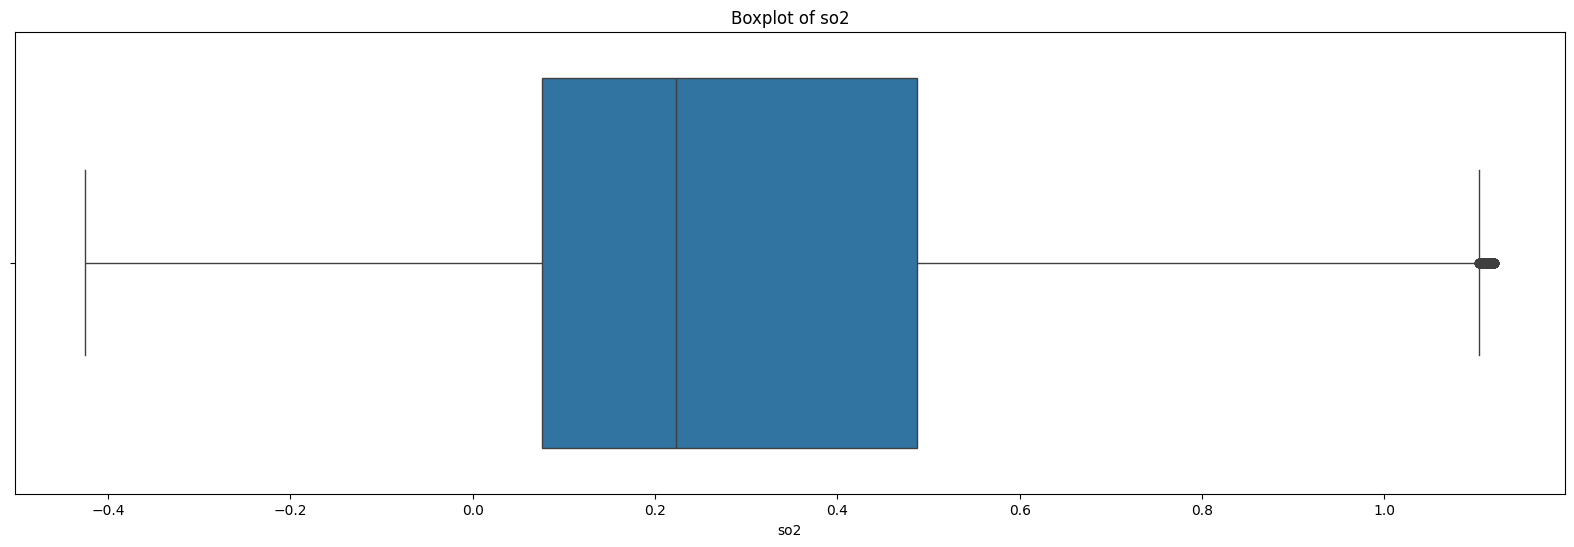

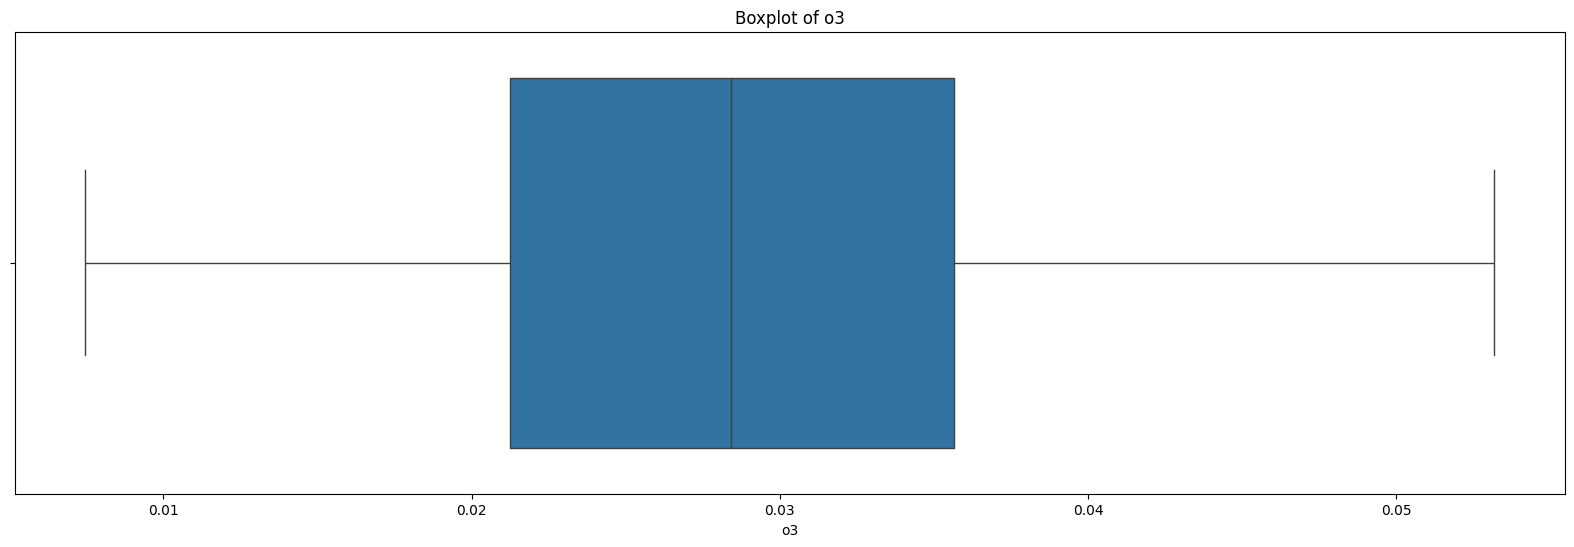

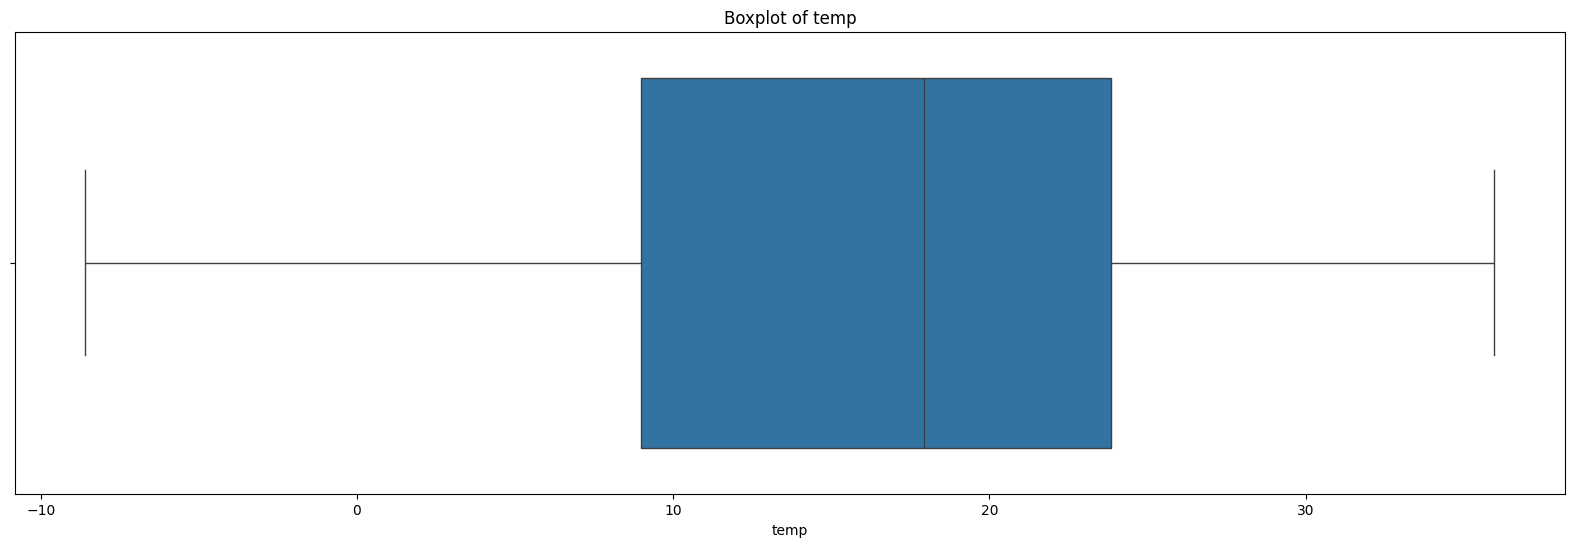

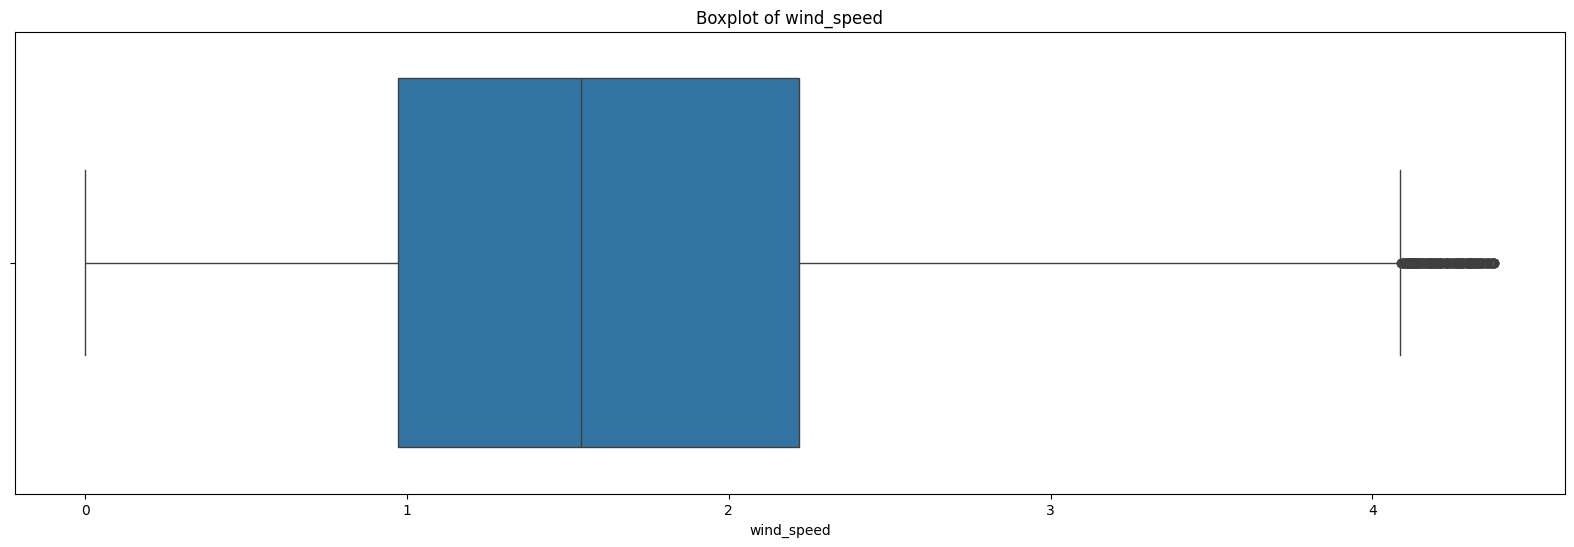

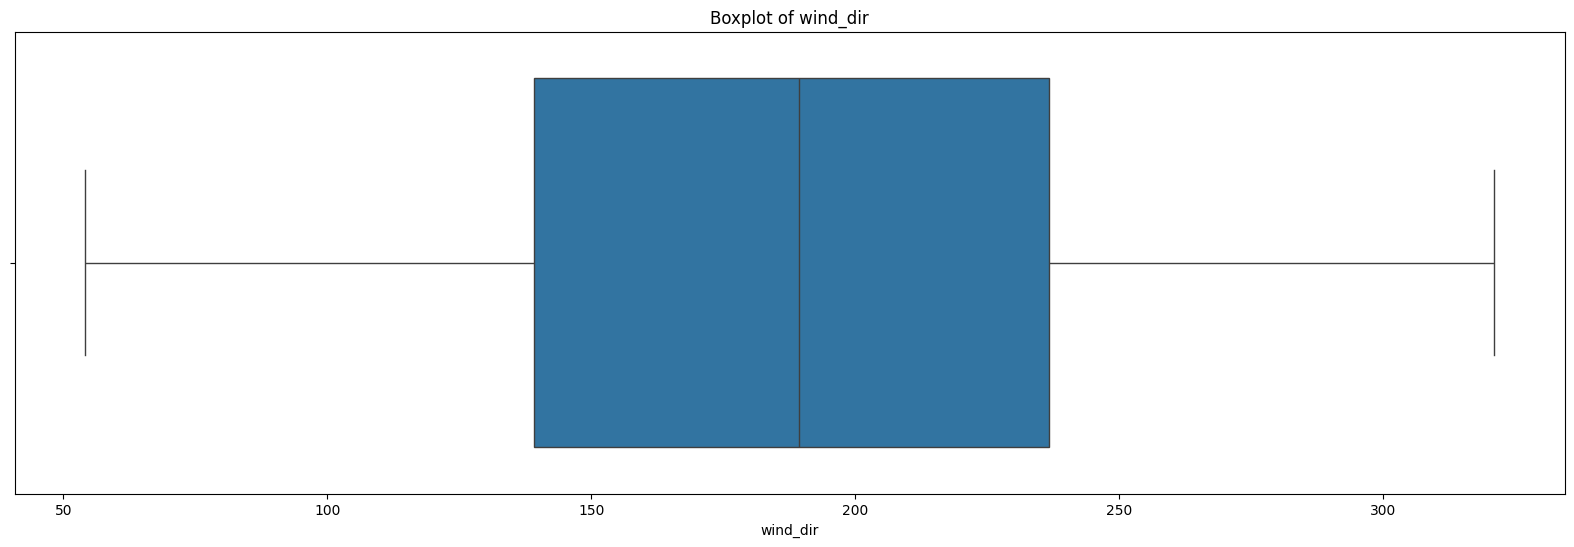

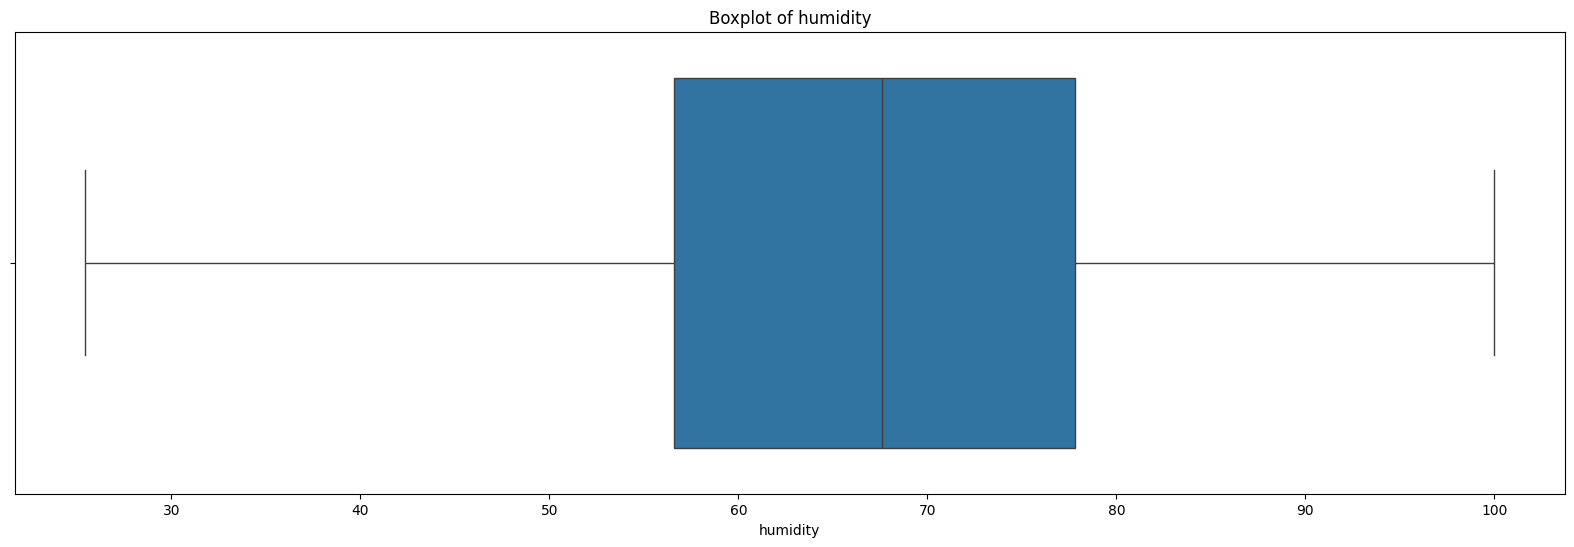

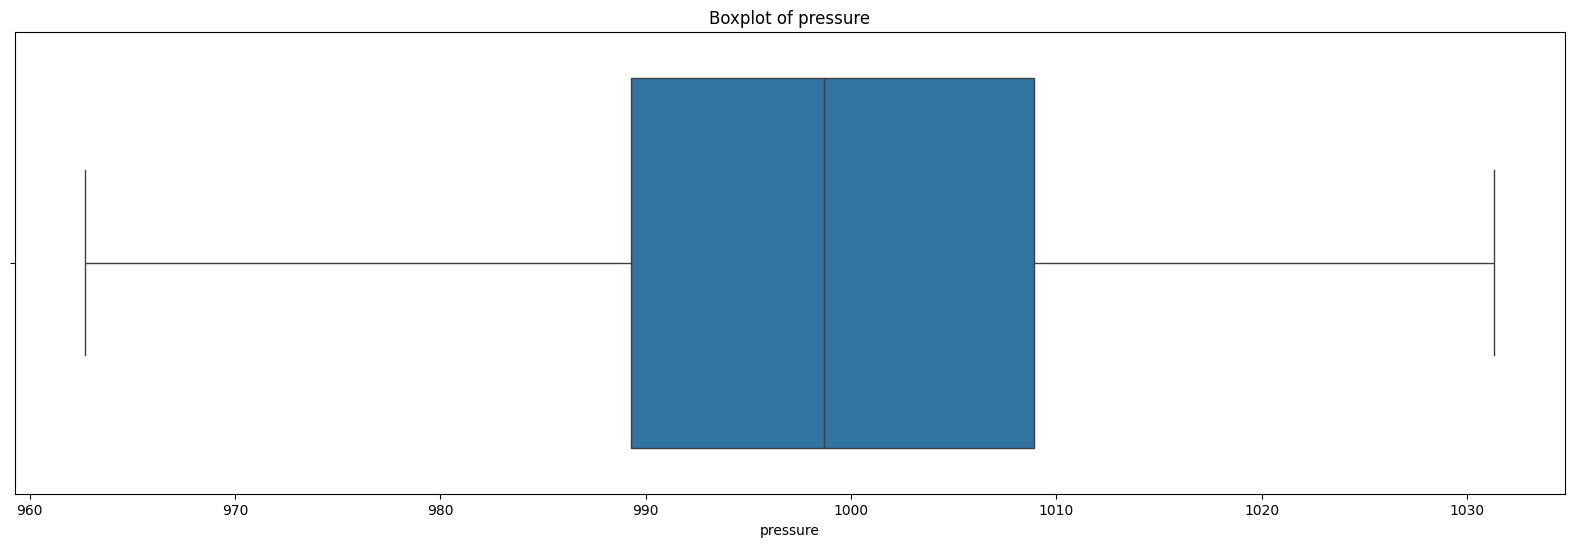

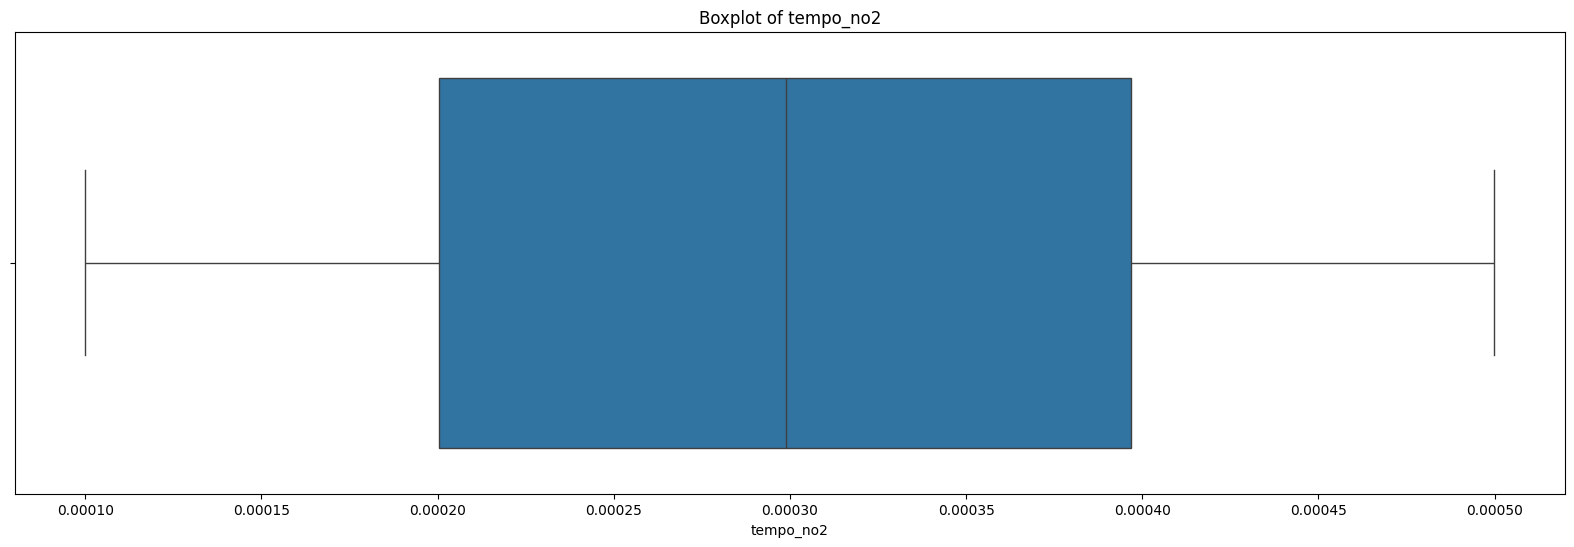

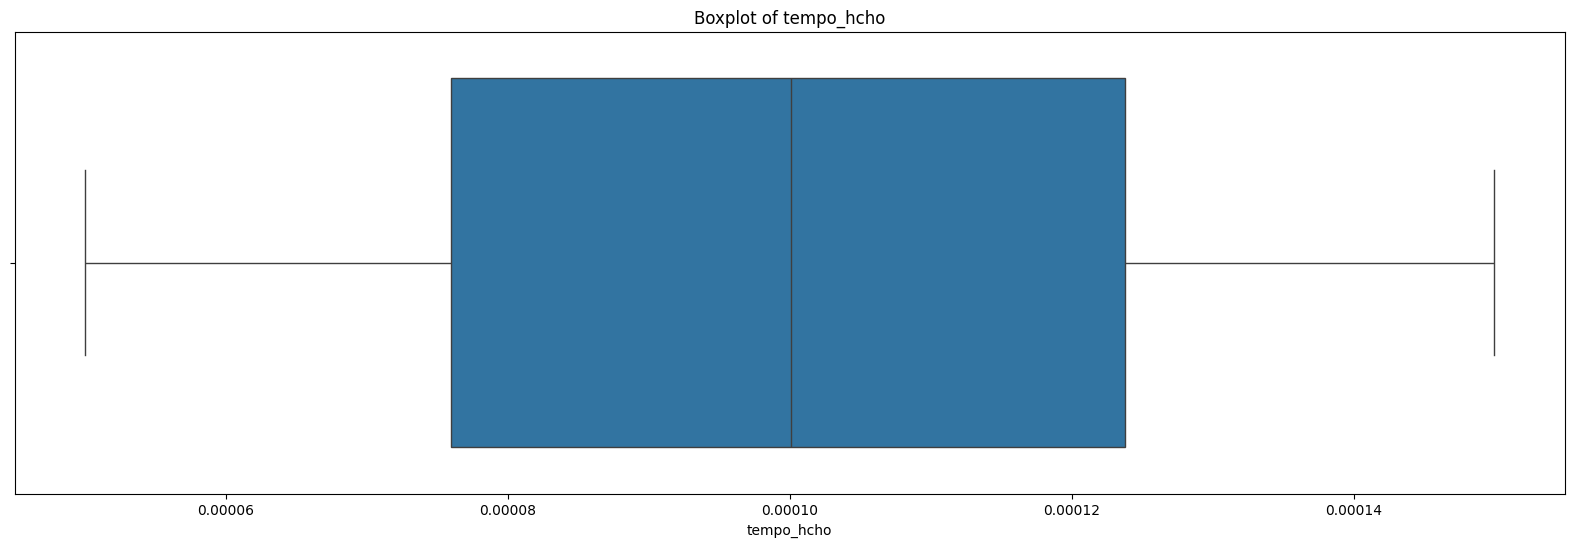

In [260]:
_box_plot(df)

# **4. Preprocessing**

## **4.1 Standardize longitude and latitude**

In [403]:
def standardize_coor(df):
    df['lat_rad'] = np.radians(df['lat'])
    df['lon_rad'] = np.radians(df['lon'])

    df['x'] = np.cos(df['lat_rad']) * np.cos(df['lon_rad'])
    df['y'] = np.cos(df['lat_rad']) * np.sin(df['lon_rad'])
    df['z'] = np.sin(df['lat_rad'])

In [404]:
standardize_coor(df)

In [405]:
df.columns

Index(['date', 'lat', 'lon', 'pm25', 'pm10', 'no2', 'co', 'so2', 'o3',
       'lat_rad', 'lon_rad', 'x', 'y', 'z'],
      dtype='object')

In [406]:
df.drop(columns=['lon_rad', 'lat_rad', 'lat', 'lon'], inplace=True)

In [407]:
df.describe()

,pm25,pm10,no2,co,so2,o3,x,y,z
count,53000.000000,53000.000000,53000.000000,53000.000000,53000.000000,53000.000000,53000.000000,53000.000000,53000.000000
mean,7.225777,16.375524,7.667491,0.207684,0.347334,0.030507,-0.016401,-0.761436,0.616037
std,3.743810,8.064203,4.517576,0.075903,0.352190,0.010715,0.182319,0.057422,0.062515
min,-3.900000,-1.000000,-4.463636,0.007021,-0.704166,0.000000,-0.420027,-0.875121,0.468942
25%,4.500000,10.000000,4.220833,0.158770,0.081250,0.022588,-0.191978,-0.783782,0.575495
50%,6.612500,15.000000,6.779167,0.200000,0.251864,0.030412,0.046302,-0.766397,0.628260
75%,9.450000,21.000000,10.313636,0.250244,0.537500,0.038118,0.130783,-0.727722,0.658456
max,19.802083,41.000000,22.154167,0.420187,1.423913,0.061529,0.239680,-0.226959,0.905166


## **4.2 Calculate AQI**

In [408]:
target_columns = ['pm25', 'pm10', 'no2', 'co', 'o3', 'so2']
# target_columns = ['pm25', 'pm10', 'no2', 'co', 'so2', 'o3', 'temp', 'wind_speed', 'wind_dir', 'humidity', 'pressure', 'tempo_no2', 'tempo_hcho']

def calculate_aqi(df):
    df['AQI_Total'] = df[target_columns].max(axis=1)
    return df

In [409]:
calculate_aqi(df)

,date,pm25,pm10,no2,co,so2,o3,x,y,z,AQI_Total
46,2001-03-26,3.700000,15.0,8.260870,0.142754,1.352795,0.030647,-0.396174,-0.712878,0.578664,15.00
49,2001-03-29,12.700000,32.0,20.782609,0.196105,1.043168,0.026765,-0.396174,-0.712878,0.578664,32.00
50,2001-03-30,8.000000,28.0,20.478261,0.324107,1.340476,0.024941,-0.396174,-0.712878,0.578664,28.00
54,2017-01-02,16.400000,21.0,9.918182,0.208250,-0.381250,0.015353,-0.079569,-0.864686,0.495970,21.00
55,2017-01-05,8.800000,14.0,7.558333,0.286230,-0.120833,0.008412,-0.079569,-0.864686,0.495970,14.00
...,...,...,...,...,...,...,...,...,...,...,...
68136,2012-12-27,7.947222,11.0,14.000000,0.217104,0.766666,0.010824,-0.081506,-0.677962,0.730565,14.00
68137,2012-12-28,9.041666,13.0,16.250000,0.286042,0.554167,0.025294,-0.081506,-0.677962,0.730565,16.25
68138,2012-12-29,14.725000,17.0,15.500000,0.155667,1.318750,0.022059,-0.081506,-0.677962,0.730565,17.00
68139,2012-12-30,10.383333,13.0,4.250000,0.185584,0.652084,0.026882,-0.081506,-0.677962,0.730565,13.00


## **4.2 Remove no need columns**

In [410]:
df.columns

Index(['date', 'pm25', 'pm10', 'no2', 'co', 'so2', 'o3', 'x', 'y', 'z',
       'AQI_Total'],
      dtype='object')

## **4.3 Min max scaler**

In [ ]:
import joblib
from sklearn.preprocessing import MinMaxScaler

exclude_cols = ['date']

def __min_max_scaler(df, save_path='scaler.pkl'):
    cols_to_scale = [c for c in df.columns if c not in exclude_cols]  # list str
    scaler = MinMaxScaler()
    scaler.fit(df[cols_to_scale].to_numpy())  # fit chỉ với numeric
    joblib.dump(scaler, save_path)

    print(f"✅ Scaler saved to {save_path}")

    return df_scaled, scaler

In [411]:
# df_scaled, _ = __min_max_scaler(df)
df_scaled = df

## **4.5 Sort by date**

In [413]:
df_scaled["date"] = pd.to_datetime(df_scaled["date"], errors="coerce")
df_scaled = df_scaled.sort_values("date").reset_index(drop=True)

assert df_scaled["date"].is_monotonic_increasing
df_scaled.index = pd.to_datetime(df_scaled['date'], format='%Y-%m-%d')

In [352]:
df.to_csv("scaled_sorted.csv", index=False)

In [378]:
df_scaled = df_scaled[df_scaled['date'] > '2010-01-01']

In [414]:
df_scaled

,date,pm25,pm10,no2,co,so2,o3,x,y,z,AQI_Total
date,,,,,,,,,,,
2001-03-26,2001-03-26,3.700000,15.0,8.260870,0.142754,1.352795,0.030647,-0.396174,-0.712878,0.578664,15.0
2001-03-29,2001-03-29,12.700000,32.0,20.782609,0.196105,1.043168,0.026765,-0.396174,-0.712878,0.578664,32.0
2001-03-30,2001-03-30,8.000000,28.0,20.478261,0.324107,1.340476,0.024941,-0.396174,-0.712878,0.578664,28.0
2006-07-23,2006-07-23,12.700000,36.0,16.666667,0.009091,0.533334,0.023588,-0.079569,-0.864686,0.495970,36.0
2006-08-07,2006-08-07,12.100000,30.0,8.181818,0.022916,1.039583,0.009294,-0.079569,-0.864686,0.495970,30.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-28,2025-06-28,3.131250,6.0,3.787500,0.195174,0.583333,0.028824,0.028475,-0.740961,0.670944,6.0
2025-06-28,2025-06-28,9.205263,11.0,5.344444,0.212127,0.000000,0.026529,0.130783,-0.806202,0.577004,11.0
2025-06-28,2025-06-28,3.476667,11.0,2.804762,0.177272,0.000000,0.037206,-0.007677,-0.748569,0.663012,11.0


## **4.6 Data splitting**

In [416]:
target_col = "AQI_Total"

def create_sequences(data, target_col, lookback):
    X, y, dates = [], [], []
    for i in range(len(data) - lookback):
        seq_X = data.iloc[i:i+lookback].drop(columns=['date', target_col]).values
        seq_y = data.iloc[i+lookback][target_col]
        seq_date = data.iloc[i+lookback]['date']
        X.append(seq_X)
        y.append(seq_y)
        dates.append(seq_date)
    return np.array(X), np.array(y), np.array(dates)

In [424]:
df_scaled

,date,pm25,pm10,no2,co,so2,o3,x,y,z,AQI_Total
date,,,,,,,,,,,
2001-03-26,2001-03-26,3.700000,15.0,8.260870,0.142754,1.352795,0.030647,-0.396174,-0.712878,0.578664,15.0
2001-03-29,2001-03-29,12.700000,32.0,20.782609,0.196105,1.043168,0.026765,-0.396174,-0.712878,0.578664,32.0
2001-03-30,2001-03-30,8.000000,28.0,20.478261,0.324107,1.340476,0.024941,-0.396174,-0.712878,0.578664,28.0
2006-07-23,2006-07-23,12.700000,36.0,16.666667,0.009091,0.533334,0.023588,-0.079569,-0.864686,0.495970,36.0
2006-08-07,2006-08-07,12.100000,30.0,8.181818,0.022916,1.039583,0.009294,-0.079569,-0.864686,0.495970,30.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-28,2025-06-28,3.131250,6.0,3.787500,0.195174,0.583333,0.028824,0.028475,-0.740961,0.670944,6.0
2025-06-28,2025-06-28,9.205263,11.0,5.344444,0.212127,0.000000,0.026529,0.130783,-0.806202,0.577004,11.0
2025-06-28,2025-06-28,3.476667,11.0,2.804762,0.177272,0.000000,0.037206,-0.007677,-0.748569,0.663012,11.0


In [417]:
df_scaled.columns

Index(['date', 'pm25', 'pm10', 'no2', 'co', 'so2', 'o3', 'x', 'y', 'z',
       'AQI_Total'],
      dtype='object')

In [418]:
lookback = 7
X, y, dates = create_sequences(df_scaled, target_col, lookback)

In [419]:
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=False
)

# **5. Training**

## **5.1 Hyperparam config**

In [420]:
wandb.init(project="NASA_AIR_QUALITY_FORECASTING", name="lstm_v2_simpleaqi_unit64_drop_d02ense32relu_dense1_batch64_1e-3",     config={
        "model": "LSTM",
        "units": 64,
        "dropout": 0.2,
        "batch_size": 64,
        "epochs": 50,
        "dense_units": 32,
        "loss": "mse",
        "optimizer": "adam",
        "learning_rate": 1e-3
    })

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
best_epoch,19
best_val_loss,41.59311
epoch,24
loss,42.18329
val_loss,42.63353


## **5.2 Training**

In [421]:
config = wandb.config
model = Sequential([
    LSTM(config.units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(config.dropout),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=config.learning_rate)
model.compile(optimizer=optimizer, loss='mse')

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_data=(X_test, y_test),
    callbacks=[
        WandbCallback(save_model=False, save_weights_only=False, save_graph=False),
        early_stop
    ],
    verbose=1
)

Epoch 1/50


/home/nguyen-quang-huy/GITHUB/My_Repo/AirForce/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


663/663 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 76.6556 - val_loss: 63.5770
Epoch 2/50
663/663 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 62.0551 - val_loss: 63.7869
Epoch 3/50
663/663 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 61.8012 - val_loss: 63.1920
Epoch 4/50
663/663 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 61.6829 - val_loss: 63.3699
Epoch 5/50
663/663 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 61.6393 - val_loss: 63.3060
Epoch 6/50
663/663 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 61.6012 - val_loss: 63.8010
Epoch 7/50
663/663 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 61.5096 - val_loss: 64.0016
Epoch 8/50
663/663 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 61.5622 - val_loss: 63.7821
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


## **5.3 True vs Predicted Value**

In [426]:
print(dates_test)
print(y_pred)


[Timestamp('2023-07-30 00:00:00') Timestamp('2023-07-30 00:00:00')
 Timestamp('2023-07-30 00:00:00') ... Timestamp('2025-06-28 00:00:00')
 Timestamp('2025-06-29 00:00:00') Timestamp('2025-06-30 00:00:00')]
[[[15.86303 ]
  [16.165695]
  [16.18634 ]
  ...
  [16.326916]
  [16.245073]
  [16.221119]]

 [[16.108055]
  [16.141582]
  [16.201492]
  ...
  [16.242956]
  [16.220217]
  [16.226143]]

 [[16.157211]
  [16.224524]
  [16.278624]
  ...
  [16.215479]
  [16.2238  ]
  [16.253916]]

 ...

 [[16.303709]
  [16.14302 ]
  [16.29803 ]
  ...
  [16.2149  ]
  [16.286098]
  [16.201027]]

 [[16.127592]
  [16.38893 ]
  [16.211924]
  ...
  [16.286488]
  [16.199121]
  [16.267359]]

 [[16.726358]
  [16.20967 ]
  [16.168533]
  ...
  [16.195833]
  [16.266851]
  [16.245901]]]


332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


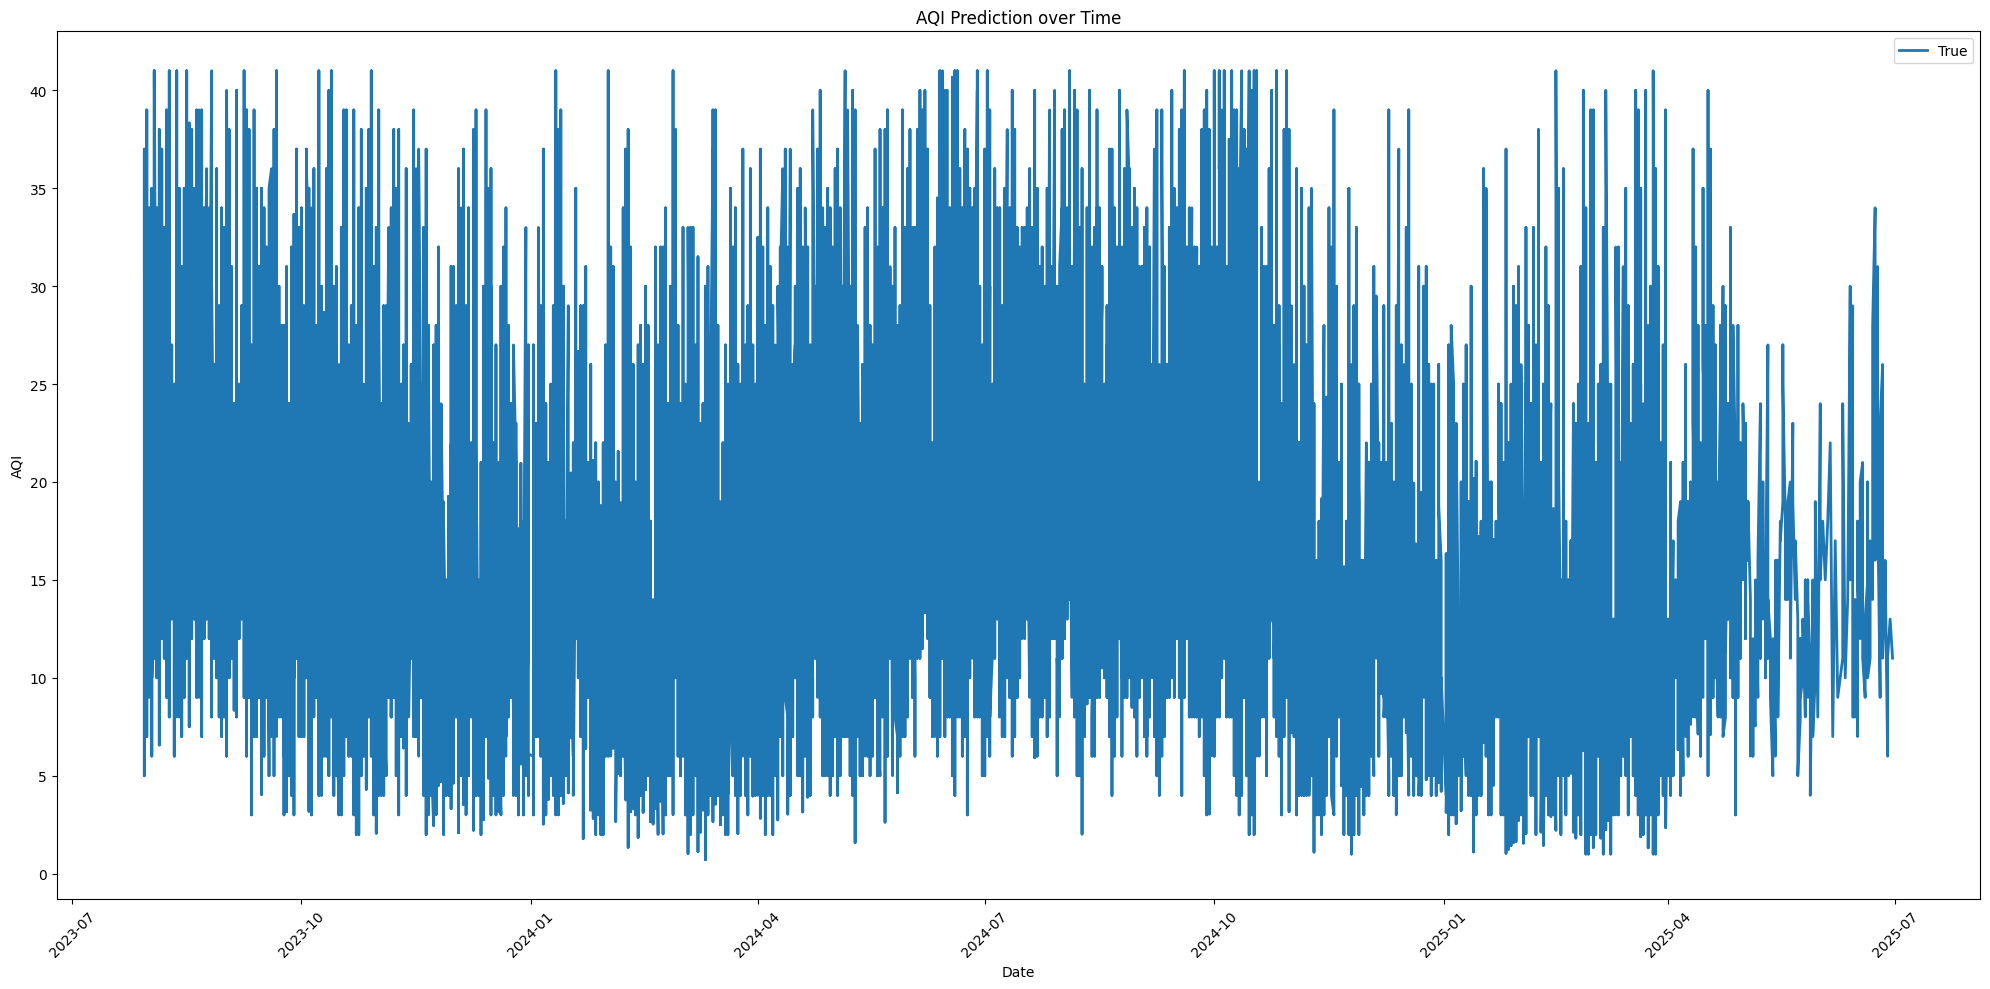

<Figure size 640x480 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt


y_pred = model.predict(X_test)
plt.figure(figsize=(20, 10))
plt.plot(dates_test, y_test, label='True', linewidth=2)
# plt.plot(dates_test, y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.title("AQI Prediction over Time")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("truevspredicted.png", dpi=300, bbox_inches='tight')

## **5.4 Train loss vs Val loss**

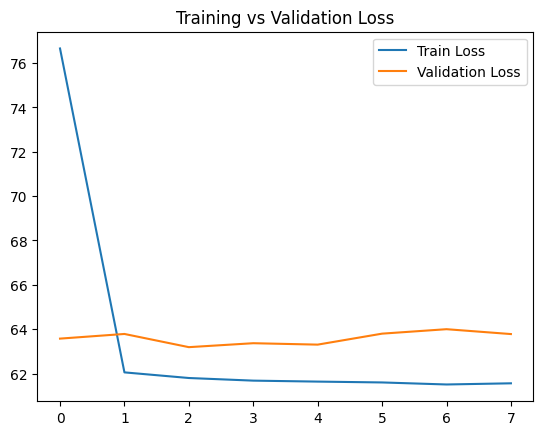

In [427]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")

plt.savefig("loss_curve.png", dpi=300, bbox_inches='tight')

In [428]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 :  {r2:.3f}")


ValueError: Found array with dim 3, while dim <= 2 is required.

In [228]:
df_scaled.columns

Index(['date', 'pm25', 'pm10', 'no2', 'co', 'so2', 'o3', 'temp', 'wind_speed',
       'wind_dir', 'humidity', 'pressure', 'tempo_no2', 'tempo_hcho',
       'lat_rad', 'lon_rad', 'x', 'y', 'z', 'AQI_Total'],
      dtype='object')

In [226]:
df_scaled.to_csv("last_dataset.csv")

# **6. Saving model**

In [431]:
model.save('lstm_global_model_4.keras', include_optimizer=True)

# **7. Testing**